We discussed some of the problems with the variational mean-field optimisation algorithms in a previous [post]({% post_url 2016-03-31-oscillating-parameters-in-variational-mean-field-approximation %}), and showed that the optimisation problem can be solved using the machine learning library `theano`. Let's try to do the same using `tensorflow`, which provides a nice optimisation interface.

Here are some simulated data.

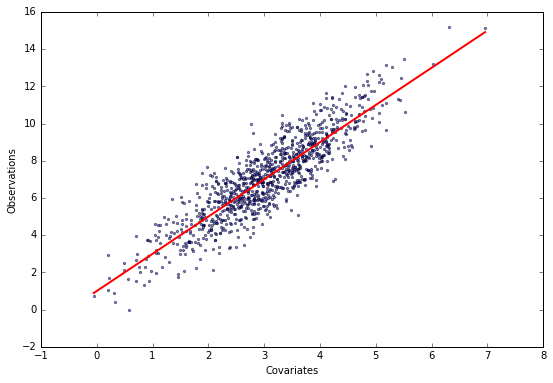

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (9, 6)
# This module contains a few helper functions
from linear_regression import *

# Generate data and plot it
X, y, theta = generate_data(theta=[1, 2])
plot_data(X, y, theta)

# Use same starting position for all optimisers
n, p = X.shape
mu0 = np.random.normal(0, 1, p)

Recall that the evidence lower bound (ELBO) is given by

$$
\mathcal{L}\left(\mu\right)= - \frac 12\sum_{i=1}^n\left(\sum_{j=k=1}^p X_{ij}\mu_jX_{ik}\mu_k-2y_i\sum_{j=1}^pX_{ij}\mu_j\right).
$$

Let's construct a symbolic computation graph in `tensorflow` to compute the ELBO.

In [2]:
import tensorflow as tf

with tf.Graph().as_default() as graph:
    # Define variables
    t_X = tf.placeholder(tf.float32, name='X')
    t_y = tf.placeholder(tf.float32, name='y')
    t_mu = tf.Variable(mu0.astype(np.float32), name='mu')

    # Compute the linear predictor
    t_predictor = tf.reduce_sum(t_X * t_mu, [1])

    # Compute the elbo
    t_elbo = -0.5 * tf.reduce_sum(t_predictor ** 2) + tf.reduce_sum(t_predictor * t_y)
    
    # Create an optimiser
    optimizer = tf.train.MomentumOptimizer(1e-2 / n, .3)
    train_step = optimizer.minimize(-t_elbo)

`tensorflow` makes use of fast libraries such as `blas` behind the scenes, and stores all data in a *session* that is decoupled from the `python` kernel. We first need to start such a session and then feed it the data. We repeatedly call the train operation of the optimiser we defined above to improve the fit of the model.

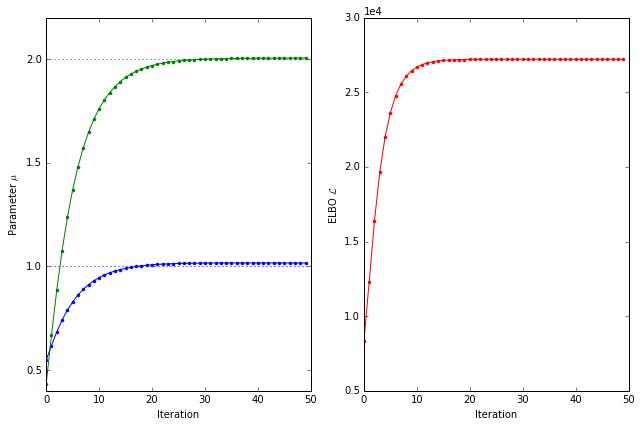

In [5]:
# Start a session
with tf.Session(graph=graph) as sess:
    # Initialise variables
    sess.run(tf.initialize_all_variables())
    
    # Run the optimisation
    trace = []
    elbos = []
    for step in range(50):
        # Call the optimisation and evaluate the current values of mu and the elbo
        _, mu, elbo = sess.run([train_step, t_mu, t_elbo], {t_X: X, t_y: y})
        trace.append(mu)
        elbos.append(elbo)
    
plot_trace(elbos, trace, theta)
pass

Let's plot the trajectory of the optimisation through parameter space.

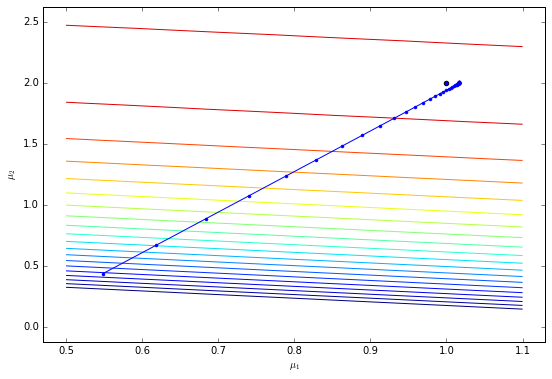

In [6]:
plot_trajectory(X, y, trace, theta, levels=np.logspace(4, 4.45, 20))

`tensorflow` and `theano` are very similar packages and are both aimed at large-scale machine learning. `tensorflow` still has a bunch of annoying pecularities (such as missing a standard implementation of the dot product), but promises to develop into a great product. It also provides a range of optimisers out of the box. `theano` is somewhat faster and more stable but optimisation is sometimes tedious because optimisers are not provided.